# Groupby and Arrest Data

<span style="color: #008080">*Revanth Chowdary Ganga (rg361)*</span>

<span style="color: #008080">*Bárbara Flores (bpf17)*</span>

In our merging exercises, we examined the relationship between county-level violent arrest totals and county-level drug arrest totals. In those exercises, you were given a dataset that provided you with county-level arrest totals. But that's not actually how the data is provided by the state of California. This week we will work with the *raw* California arrest data, which is not organized by county or even county-year. 



## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_groupby.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex4_num_rows",
    "ex5_collapsed_vars",
    "ex7_alameda_1980_share_violent_arrestees_black",
    "ex11_white_drug_share",
    "ex11_black_drug_share",
    "ex12_proportionate",
}
```


### Submission Limits

Please remember that you are **only allowed three submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.

### Exercise 1

Import the raw California arrest data from the State Attorney General's office. Please use [this link](https://github.com/nickeubank/MIDS_Data/blob/master/OnlineArrestData1980-2021.csv) (the original is here [here](https://openjustice.doj.ca.gov/data), but they keep updating it and I get tired of updating solutions, so... please use my copy!)

In [1]:
# importing required packages and libraries
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Setting Default Options
pd.set_option("mode.copy_on_write", True)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
# Loading Data
path = "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/OnlineArrestData1980-2021.csv"
OnlineArrestData = pd.read_csv(path)
OnlineArrestData.head()

,YEAR,GENDER,RACE,AGE_GROUP,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL
0,1980,Male,Black,Under 18,Alameda County,505,1351,188,26,79,2149,2286,295
1,1980,Male,Black,18 to 19,Alameda County,205,465,183,8,48,909,1333,0
2,1980,Male,Black,20 to 29,Alameda County,949,1593,606,27,178,3353,7974,0
3,1980,Male,Black,30 to 39,Alameda County,450,755,241,18,110,1574,4876,0
4,1980,Male,Black,40 to 69,Alameda County,172,218,117,11,66,584,3836,0


## Learning the Group Structure of Your Data

### Exercise 2

What is the unit of observation for this dataset? In other words, when row zero says that there were 505 arrests for `VIOLENT` crimes, what exactly is that telling you—505 arrests in 1980? 505 arrests in Alameda County?

(Please answer in Markdown)

><span style="color: #008080">*Our assumption is that the unit of observation is the number of arrests by year, gender, race, age group, and county.*</span>
>
><span style="color: #008080">*For example, in the first row of the dataframe, there were 505 arrests for 'VIOLENT' crimes that occurred in 1980 in Alameda County for male individuals of Black race and under 18 years of age.*</span>

### Testing Your Assumptions

It's important to be able to test whether the data you are working with really is organized the way you think it is, especially when working with groupby. Let's discuss how to check your answer to Exercise 2 with the `.duplicated()` method. 

Consider the following toy data:

In [4]:
import pandas as pd

df = pd.DataFrame(
    {
        "social_security_numbers": [
            111111111,
            222222222,
            222222222,
            333333333,
            333333333,
        ],
        "second_column": ["a", "a", "a", "a", "b"],
    }
)
df

,social_security_numbers,second_column
0,111111111,a
1,222222222,a
2,222222222,a
3,333333333,a
4,333333333,b


If we want to see if there are any duplicate rows in the dataset, we can use the `.duplicated()` method:

In [5]:
df.duplicated()

0    False
1    False
2     True
3    False
4    False
dtype: bool

As you can see, `.duplicated()` looks at each row and returns `True` if it has seen the row it is looking at before. 

Notice that `.duplicted()` doesn't return `True` for *all* rows that look the same as another row in the data—it treats the first instance of a row as unique, and only tags *subsequent* repetitions as "duplicates" (You can change this behavior with the `keep` keyword argument if you want).

`.duplicated()` can also be used to test for rows that are duplicates in terms of a sub-set of columns. For example, `df.duplicated(["social_security_numbers"])` identifies rows with duplicate values of the variable `social_security_numbers`:

In [6]:
df.duplicated(["social_security_numbers"])

0    False
1    False
2     True
3    False
4     True
dtype: bool

Since `duplicated` is now only looking at `social_security_numbers` (not all values in a row), the last row is now a duplicate (because `333333333` is duplicated), where when we considered all columns, it was not a duplicate. 

### Testing with .duplicated()

`.duplicated()` can be paired with the `.any()` method to write `assert` tests to detect the presence of duplicates in our dataset and to validate our assumptions about whether certain variables uniquely identify observations in our data.

When you run `.any()` on an array of Booleans, it returns a single value of `True` if *any* entries are `True`, and a single value of `False` if *no* entries are `True`. (You can also use `.all()` to test if all entries are `False`).

Thus the command `df.duplicated(['social_security_numbers'])` will return `False` if `social_security_numbers` uniquely identifies every row in our dataset (since there are no duplicates)! But if there *are* any duplicates, it will return `True`:

In [7]:
df.duplicated(["social_security_numbers"]).any()

True

So if I wanted a test that would raise an `Error` if it turned out that `social_security_numbers` *didn't* uniquely identify observations, I would combine that code with `assert not`:

```python
assert not df.duplicated(["social_security_numbers"]).any()

---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In [20], line 1
----> 1 assert not df.duplicated(["social_security_numbers"]).any()

AssertionError: 
```

(which in this case raises an Error because `social_security_numbers` *isn't* unique!)

BTW, if this feels oddly familiar, that's probably because we talked about this same idea when discussing merging. A `1:1` merge is one in which the merging variables uniquely identify observations in both datasets.

### Exercise 3

Use `duplicated` to test if the variables *you* think uniquely identify rows in your data really do uniquely identify rows. If you were wrong, update your beliefs (and your code) until you have an `assert` statement that passes.

In [8]:
unit_dimensions = ["YEAR", "GENDER", "RACE", "AGE_GROUP", "COUNTY"]

assert not OnlineArrestData.duplicated(unit_dimensions).any()

><span style="color: #008080">*By using the duplicated function, we were able to confirm that our original assumption was correct. We can see that we indeed have one unique row for each combination of 'YEAR,' 'GENDER,' 'RACE,' 'AGE_GROUP,' and 'COUNTY.'*</span>

### Exercise 4

Once you have a handle on how the data looks now, please **collapse the data** to be one observation per county-year-racial group. Store the number of rows in the resulting dataframe in your `results` dictionary under the key `"ex4_num_rows"`.

**Hint:** Think carefully about the most appropriate *aggregation function* (e.g., mean, median, sum, count) given the data we're working with!

**Hint 2:** When using `groupby`, I am a HUGE fan of the `as_index=False` keyword argument (e.g., `df.groupby("col1", as_index=False).mean()`). By default when you use groupby, pandas likes to make a new index out of the grouping columns. As you know, I HATE indices, and this keyword argument prevents pandas from this behavior. To illustrate:

In [9]:
df = pd.DataFrame(
    {
        "social_security_numbers": [
            111111111,
            222222222,
            222222222,
            222222222,
            333333333,
        ],
        "second_column": ["a", "a", "b", "a", "b"],
        "third_column": [100, 200, 300, 400, 500],
    }
)
df

,social_security_numbers,second_column,third_column
0,111111111,a,100
1,222222222,a,200
2,222222222,b,300
3,222222222,a,400
4,333333333,b,500


In [10]:
# Without as_index=False
df.groupby(["social_security_numbers", "second_column"]).mean()

third_column
social_security_numbers second_column              
111111111               a                     100.0
222222222               a                     300.0
                        b                     300.0
333333333               b                     500.0

In [11]:
# With as_index=False
df.groupby(["social_security_numbers", "second_column"], as_index=False).mean()

,social_security_numbers,second_column,third_column
0,111111111,a,100.0
1,222222222,a,300.0
2,222222222,b,300.0
3,333333333,b,500.0


In [12]:
# Answer:
grouping_columns = ["RACE", "YEAR", "COUNTY"]

OnlineArrestData_per_county_year_race = OnlineArrestData.groupby(
    grouping_columns, as_index=False
)[
    [
        "VIOLENT",
        "PROPERTY",
        "F_DRUGOFF",
        "F_SEXOFF",
        "F_ALLOTHER",
        "F_TOTAL",
        "M_TOTAL",
        "S_TOTAL",
    ]
].sum()

OnlineArrestData_per_county_year_race.head()

,RACE,YEAR,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL
0,Black,1980,Alameda County,2594,5138,1489,94,541,9856,24081,555
1,Black,1980,Butte County,32,33,5,0,7,77,139,0
2,Black,1980,Calaveras County,0,0,0,0,0,0,7,0
3,Black,1980,Colusa County,0,5,0,0,0,5,13,0
4,Black,1980,Contra Costa County,720,1422,368,24,257,2791,5201,40


In [13]:
results = dict()
ex4_num_rows = len(OnlineArrestData_per_county_year_race)
results["ex4_num_rows"] = ex4_num_rows
print(
    f"The number of rows in the resulting dataframe, grouped by county, year and racial group, is {ex4_num_rows:,}."
)

The number of rows in the resulting dataframe, grouped by county, year and racial group, is 9,702.


### Exercise 5

You should notice that there are significantly fewer rows in the data now. Given your answer from 3, what groups were you *collapsing* in question 4 (in other words, which different groups were previously split out into separate rows but have now been aggregated into the same rows)?

Store the names of those variables **in a `list` in alphabetical order** in `results` as `"ex5_collapsed_vars"`.

In [14]:
ex5_collapsed_vars = [
    dimension for dimension in unit_dimensions if dimension not in grouping_columns
]
ex5_collapsed_vars.sort()
results["ex5_collapsed_vars"] = ex5_collapsed_vars

print(f"In question 4, we collapsed the groups: {', '.join(ex5_collapsed_vars)}.")

In question 4, we collapsed the groups: AGE_GROUP, GENDER.


## Racial Arrest Composition

The next question we want to ask is: does the racial composition of arrests in each county vary by arrest type? In other words, do Blacks, Hispanics, Whites, and Other make up substantially different portions of the people arrested for drug offenses and violent offenses?

To answer this question, we need to be able to say what proportion of all drug arrestees were Black/White/Hispanic/Other and what proportion of all violent arrestees were Black/White/Hispanic/Other *for each county and for each year*.

In trying to do this, we'll need to break the problem down into pieces, starting from our goal (these quantities) and working backwards.

### Exercise 6

To calculate the share of all drug and violent arrestees who come from each racial group, what quantities do we need? 

Expressed differently, what two variables (one for drug arrests, one for violent arrests) do we need to add to our data to it allow us to calculate the share of arrestees in each county-year that come from a given racial group?

Calculate these two variables (one variable for drug arrests, one for violent arrests). 

**Hint:** `transform` should probably make an appearance here.

**Hint:** This types of groupby manipulations are an easy place to do things wrong, so it's important to eye-ball your data to be sure you did things right! 

Take a look at the data for, say, Alameda County in 1980, and compare the values that you calculate above with what you get if you try to calculate those same numbers by hand using the raw data from Exercise 5?

><span style="color: #008080">*To answer our question about Racial Arrest Composition, we will first calculate 2 variables using the `transform` method:*</span>
>
><span style="color: #008080">*- SUM_VIOLENT_BY_COUNTY_YEAR*: which calculates the sum of violent arrests by county and year.</span>
>
><span style="color: #008080">*- SUM_F_DRUGOFF_BY_COUNTY_YEAR*: which calculates the sum of drug-related arrests by county and year.</span>
>
><span style="color: #008080">*These variables will help us analyze the racial composition of arrests for violent and drug-related offenses.*</span>


In [15]:
OnlineArrestData_per_county_year_race[
    "SUM_VIOLENT_BY_COUNTY_YEAR"
] = OnlineArrestData_per_county_year_race.groupby(["YEAR", "COUNTY"])[
    "VIOLENT"
].transform(
    sum
)

OnlineArrestData_per_county_year_race[
    "SUM_F_DRUGOFF_BY_COUNTY_YEAR"
] = OnlineArrestData_per_county_year_race.groupby(["YEAR", "COUNTY"])[
    "F_DRUGOFF"
].transform(
    sum
)

OnlineArrestData_per_county_year_race.head()

,RACE,YEAR,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,SUM_VIOLENT_BY_COUNTY_YEAR,SUM_F_DRUGOFF_BY_COUNTY_YEAR
0,Black,1980,Alameda County,2594,5138,1489,94,541,9856,24081,555,4504,3569
1,Black,1980,Butte County,32,33,5,0,7,77,139,0,306,149
2,Black,1980,Calaveras County,0,0,0,0,0,0,7,0,52,83
3,Black,1980,Colusa County,0,5,0,0,0,5,13,0,28,9
4,Black,1980,Contra Costa County,720,1422,368,24,257,2791,5201,40,1596,1089


><span style="color: #008080">*To verify the correctness of our previous calculations, we will take Alameda County in 1980 as an example and compare the values of the SUM_VIOLENT_BY_COUNTY_YEAR and SUM_F_DRUGOFF_BY_COUNTY_YEAR columns with the values we would obtain if we manually calculated those same numbers using the raw data from Exercise 5.*</span>


In [16]:
OnlineArrestData_per_county_year_race.groupby(["YEAR", "COUNTY"], as_index=False)[
    ["VIOLENT", "F_DRUGOFF"]
].sum().head()

,YEAR,COUNTY,VIOLENT,F_DRUGOFF
0,1980,Alameda County,4504,3569
1,1980,Alpine County,1,2
2,1980,Amador County,10,12
3,1980,Butte County,306,149
4,1980,Calaveras County,52,83


In [17]:
OnlineArrestData_per_county_year_race[
    (OnlineArrestData_per_county_year_race["COUNTY"] == "Alameda County")
    & (OnlineArrestData_per_county_year_race["YEAR"] == 1980)
].reset_index()

,index,RACE,YEAR,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,SUM_VIOLENT_BY_COUNTY_YEAR,SUM_F_DRUGOFF_BY_COUNTY_YEAR
0,0,Black,1980,Alameda County,2594,5138,1489,94,541,9856,24081,555,4504,3569
1,2402,Hispanic,1980,Alameda County,592,903,361,34,279,2169,10120,333,4504,3569
2,4832,Other,1980,Alameda County,139,233,69,10,64,515,2686,92,4504,3569
3,7266,White,1980,Alameda County,1179,3103,1650,119,767,6818,34455,1358,4504,3569


><span style="color: #008080">*"We could verify that in both cases, we have 4,504 violent arrests and 3,569 drug-related arrests for Alameda County in 1980."*</span>

### Exercise 7

Now calculate the share of violent and drug arrestees in each county and year from each racial group.

To ensure you're on the right track, store the share (between zero and one) of violent arrestees in Alameda County in 1980 who were Black as `ex7_alameda_1980_share_violent_arrestees_black`.

In [18]:
OnlineArrestData_per_county_year_race["SHARE_VIOLENT_BY_RACE"] = (
    OnlineArrestData_per_county_year_race["VIOLENT"]
    / OnlineArrestData_per_county_year_race["SUM_VIOLENT_BY_COUNTY_YEAR"]
)

OnlineArrestData_per_county_year_race["SHARE_DRUG_BY_RACE"] = (
    OnlineArrestData_per_county_year_race["F_DRUGOFF"]
    / OnlineArrestData_per_county_year_race["SUM_F_DRUGOFF_BY_COUNTY_YEAR"]
)

OnlineArrestData_per_county_year_race.head()

,RACE,YEAR,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,SUM_VIOLENT_BY_COUNTY_YEAR,SUM_F_DRUGOFF_BY_COUNTY_YEAR,SHARE_VIOLENT_BY_RACE,SHARE_DRUG_BY_RACE
0,Black,1980,Alameda County,2594,5138,1489,94,541,9856,24081,555,4504,3569,0.575933,0.417204
1,Black,1980,Butte County,32,33,5,0,7,77,139,0,306,149,0.104575,0.033557
2,Black,1980,Calaveras County,0,0,0,0,0,0,7,0,52,83,0.000000,0.000000
3,Black,1980,Colusa County,0,5,0,0,0,5,13,0,28,9,0.000000,0.000000
4,Black,1980,Contra Costa County,720,1422,368,24,257,2791,5201,40,1596,1089,0.451128,0.337925


In [19]:
ex7_alameda_1980_share_violent_arrestees_black = OnlineArrestData_per_county_year_race[
    (
        (OnlineArrestData_per_county_year_race["RACE"] == "Black")
        & (OnlineArrestData_per_county_year_race["YEAR"] == 1980)
        & (OnlineArrestData_per_county_year_race["COUNTY"] == "Alameda County")
    )
]["SHARE_VIOLENT_BY_RACE"][0]

results[
    "ex7_alameda_1980_share_violent_arrestees_black"
] = ex7_alameda_1980_share_violent_arrestees_black

print(
    f"The share of violent arrestees who were Black in Alameda County in 1980 is {ex7_alameda_1980_share_violent_arrestees_black:.3f}"
)

The share of violent arrestees who were Black in Alameda County in 1980 is 0.576


### Exercise 8

We're about to start studying this data by plotting the share of violent arrestees that are Black against the share of felony drug arrestees that are Black. But the moment where you finish your data manipulations and are about to start you data analysis is a *great* time to just make sure everything in your data looks good. Let's run a few checks:

- Are your values of the share of felony arrestees who were arrested for violent crimes sensible?
- You're about to analyze the data using only the rows for the Black racial group. How many unique counties are there with data for Black arrestees? How many for White arrestees? Do you remember how many counties there are in CA (google is your friend if not!)?

Include assert statements to check all these features of your data.

(Reminder: the autograder will only work if you are entire notebook runs without errors.)

If you encounter any problems, make sure you understand why they are happening, and fix them (if a fix is appropriate!).

In [20]:
# Check if all violent arrest values are within range
assert np.logical_and(
    OnlineArrestData_per_county_year_race["SHARE_VIOLENT_BY_RACE"] >= 0,
    OnlineArrestData_per_county_year_race["SHARE_VIOLENT_BY_RACE"] <= 1,
).all()

print("The Share of Violent arrests are within Range (0,1)")

The Share of Violent arrests are within Range (0,1)


In [21]:
# Count number of unique counties with black arrests
black_counties = OnlineArrestData_per_county_year_race[
    OnlineArrestData_per_county_year_race["RACE"] == "Black"
]["COUNTY"].nunique()

# check if all counties are present, California has 58 counties
assert black_counties == 58
print(f"There are {black_counties} out of expected 58 counties with Black arrests")

There are 58 out of expected 58 counties with Black arrests


In [22]:
# Count number of unique counties with White arrests
white_counties = OnlineArrestData_per_county_year_race[
    OnlineArrestData_per_county_year_race["RACE"] == "White"
]["COUNTY"].nunique()

# check if all counties are present, California has 58 counties
assert white_counties == 58
print(f"There are {white_counties} out of expected 58 counties with White arrests")

There are 58 out of expected 58 counties with White arrests


><span style="color: #008080">*We verified that the share of violent arrests are within the expected range and that we have data from all 58 counties in California for Black and White arrests*</span>

### Exercise 9

Now check to see if you have the same number of counties *in each year for each racial group*.

Can you figure out why there aren't? (Hint: this isn't trivial to figure out! You'll probably have to do some detective work, and even then you'll have to make a bit of a "best guess" at what's going on!)

In [23]:
# create and store Dataframes with Unique Race, County and Years from the Dataset
race = pd.DataFrame({"RACE": OnlineArrestData_per_county_year_race["RACE"].unique()})
county = pd.DataFrame(
    {"COUNTY": OnlineArrestData_per_county_year_race["COUNTY"].unique()}
)
yrs = pd.DataFrame({"YEAR": OnlineArrestData_per_county_year_race["YEAR"].unique()})

In [24]:
# Perform a Cross-Join to get all possible combinations
df_combo = race.merge(county, how="cross")
df_combo = df_combo.merge(yrs, how="cross")

In [25]:
df_combo.sample(5)

,RACE,COUNTY,YEAR
2091,Black,Trinity County,2013
128,Black,Colusa County,1982
8427,White,Nevada County,2007
8043,White,Madera County,2001
310,Black,Fresno County,1996


In [26]:
# Perform Left-Join with Indicator to see which combinations are missing from original dataset
df_missing = df_combo.merge(
    OnlineArrestData_per_county_year_race[["RACE", "COUNTY", "YEAR"]],
    on=["RACE", "COUNTY", "YEAR"],
    how="left",
    indicator=True,
)

total_combi = df_combo.shape[0]
missing_combi = df_missing[df_missing["_merge"] == "left_only"].shape[0]
print(
    f"From the {total_combi:,} possible combinations of Race, County and Year, {missing_combi} combinations are missing in the Dataset"
)

From the 9,744 possible combinations of Race, County and Year, 42 combinations are missing in the Dataset


In [27]:
df_missing[df_missing["_merge"] == "left_only"]

,RACE,COUNTY,YEAR,_merge
802,Black,Mariposa County,1984,left_only
926,Black,Modoc County,1982,left_only
930,Black,Modoc County,1986,left_only
931,Black,Modoc County,1987,left_only
947,Black,Modoc County,2003,left_only
981,Black,Mono County,1995,left_only
2059,Black,Trinity County,1981,left_only
2062,Black,Trinity County,1984,left_only
2064,Black,Trinity County,1986,left_only
2065,Black,Trinity County,1987,left_only


### Exercise 10

Once you think you have a theory of the case, fix the problem. Again, this will NOT be trivial.

><span style="color: #008080">*Our hypothesis after checking the population data for these combinations online is that since they had very low or no Black population, it is possible that there were no crime records for black population in these combinations. To correct this we will add these combinations with 0 in the dataset*</span>

In [28]:
# Create a new DF by merging the combo DF with the original Dataset
df_main = df_combo.merge(
    OnlineArrestData_per_county_year_race,
    on=["RACE", "COUNTY", "YEAR"],
    how="left",
    indicator=True,
)

In [29]:
# view Combinations which don't have data in orignial dataset
df_main[df_main["_merge"] == "left_only"]

,RACE,COUNTY,YEAR,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,SUM_VIOLENT_BY_COUNTY_YEAR,SUM_F_DRUGOFF_BY_COUNTY_YEAR,SHARE_VIOLENT_BY_RACE,SHARE_DRUG_BY_RACE,_merge
802,Black,Mariposa County,1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
926,Black,Modoc County,1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
930,Black,Modoc County,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
931,Black,Modoc County,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
947,Black,Modoc County,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
981,Black,Mono County,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2059,Black,Trinity County,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2062,Black,Trinity County,1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2064,Black,Trinity County,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2065,Black,Trinity County,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [30]:
# Fill 0 as default value only for these combinations
df_main[df_main["_merge"] == "left_only"] = df_main[
    df_main["_merge"] == "left_only"
].fillna(0)

### Exercise 11

Now that you have corrected your problem, averaging over the values for each county-year, calculate the average share of drug arrestees who are Black and the average share of drug arrestees who are White. Store the results as `"ex11_white_drug_share"` and `"ex11_black_drug_share"`.

In [31]:
# Drug arrests who are black
results["ex11_black_drug_share"] = df_main[df_main["RACE"] == "Black"][
    "SHARE_DRUG_BY_RACE"
].mean()

# Drug arrests who are White
results["ex11_white_drug_share"] = df_main[df_main["RACE"] == "White"][
    "SHARE_DRUG_BY_RACE"
].mean()

print(
    f"""On an average at a county-year level, Black arrestees make up {results["ex11_black_drug_share"]:.2%} of the arrests for Drugs while Whites makes up {results["ex11_white_drug_share"]:.2%}"""
)

On an average at a county-year level, Black arrestees make up 9.19% of the arrests for Drugs while Whites makes up 62.01%


### Exercise 12

Plot the share of violent arrestees that are Black against the share of felony drug arrestees that are Black. Do they look proportionate? Answer in text here.

Do Black arrestees make up a greater share of violent arrestees, or a greater share of drug arrestees? Store you answer as `"greater violent"`, or `"greater drug"` in `"ex12_proportionate"`.

**Hint:** You can add a 45 degree reference line by making a dummy dataset with one point at 0,0 and one point at a location near the top of your data (e.g. 0.7, 0.7). Without a reference line it's VERY hard to be sure if how your points relate to proportionality.

(A quick note of warning on interpretation: these results can tell you whether Black Californians make up a larger proportion of *arrests* for certain types of crimes, not whether they make up a larger proportion of people who *commit* a give type of crime! Those *might* be the same, but they might not... this data just can't answer that question.)

Text(0.5, 0, 'Share of Drug Arrests')

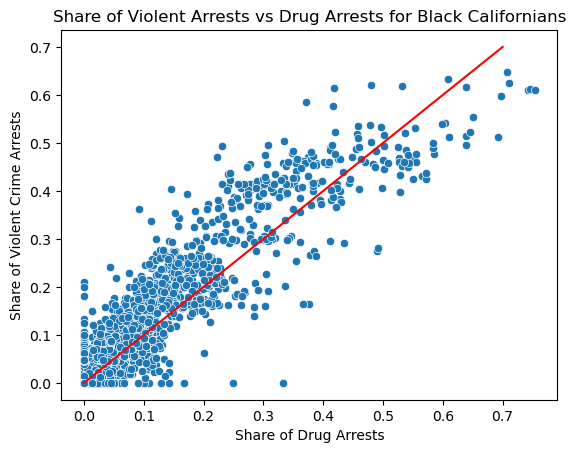

In [32]:
sns.scatterplot(
    data=df_main[df_main["RACE"] == "Black"],
    x="SHARE_DRUG_BY_RACE",
    y="SHARE_VIOLENT_BY_RACE",
)


# Add a 45 degree line
x = [0, 0.7]
plt.plot(x, x, color="red")

# Add Labels
plt.title("Share of Violent Arrests vs Drug Arrests for Black Californians")
plt.ylabel("Share of Violent Crime Arrests")
plt.xlabel("Share of Drug Arrests")

In [33]:
# Save to Results
results["ex12_proportionate"] = "greater violent"
print("Black arrestees make up a greater share of violent arrestees")

Black arrestees make up a greater share of violent arrestees


><span style="color: #008080">*Based on the graph, Black arrestees make up a greater share of violent crimes as compared to drug related crimes. while there are some exceptions, overall they seem to be proportionate*</span>

In [34]:
# View Results
results

{'ex4_num_rows': 9702,
 'ex5_collapsed_vars': ['AGE_GROUP', 'GENDER'],
 'ex7_alameda_1980_share_violent_arrestees_black': 0.5759325044404974,
 'ex11_black_drug_share': 0.0919444129480198,
 'ex11_white_drug_share': 0.620058054736359,
 'ex12_proportionate': 'greater violent'}

In [35]:
# Checking if all result keys Match
assert set(results.keys()) == {
    "ex4_num_rows",
    "ex5_collapsed_vars",
    "ex7_alameda_1980_share_violent_arrestees_black",
    "ex11_white_drug_share",
    "ex11_black_drug_share",
    "ex12_proportionate",
}